In [12]:
#!pip install pandas pyarrow yfinance fortitudo_tech matplotlib numpy
#!pip install alpaca-py seaborn fredapi python-dotenv cvxopt

In [2]:
"""
FFR Walk-Forward Backtest — Block 1: Data & Setup
==================================================
Fetches and prepares all data needed for the backtest.
Assets via Alpaca, macro via yfinance.

Contrary to previous configurations, BTU replaced by OKE (full membership since 2010), and APO by GS.
"""

import os
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import date
from dotenv import load_dotenv

load_dotenv("env")

# ── config ──
assets = [
    'NVDA', 'ISRG', 'GS', 'DECK', 'COST', 'CAT',
    'OKE', 'SHW', 'NRG', 'NFLX', 'CBRE'
]
commodities = ['GC=F']
macro_tickers = ['^VIX', '^GSPC']
start_date = "2016-01-01"
today = date.today().isoformat()


# ── stock data (alpaca) ──
def fetch_stocks(tickers, start, end):
    from alpaca.data.historical import StockHistoricalDataClient
    from alpaca.data.requests import StockBarsRequest
    from alpaca.data.timeframe import TimeFrame, TimeFrameUnit
    from alpaca.data.enums import DataFeed, Adjustment

    client = StockHistoricalDataClient(
        api_key=os.environ['ALPACA_API_KEY'],
        secret_key=os.environ['ALPACA_SECRET_KEY']
    )
    req = StockBarsRequest(
        symbol_or_symbols=tickers,
        timeframe=TimeFrame(1, TimeFrameUnit.Day),
        start=pd.to_datetime(start),
        end=pd.to_datetime(end),
        adjustment=Adjustment.ALL,
        feed=DataFeed.SIP
    )
    bars = client.get_stock_bars(req).df.reset_index()
    bars['date'] = bars['timestamp'].dt.date
    return bars.pivot_table(index='date', columns='symbol', values='close')


# ── macro data (yfinance) ──
def fetch_macro(tickers, start, end):
    df = yf.download(tickers, start=start, end=end, auto_adjust=True)
    if isinstance(df.columns, pd.MultiIndex):
        df = df['Close']
    df.index = pd.to_datetime(df.index).date
    df.index.name = 'date'
    df.interpolate(method='linear', inplace=True)
    return df


# ── merge & clean ──
def build_dataset(stocks, comms, macro):
    prices = pd.merge(stocks, comms, left_index=True, right_index=True, how='inner')
    prices = prices.dropna(axis=0, how='any')

    state_vars = pd.DataFrame({
        'SP500_ret': np.log(macro['^GSPC'] / macro['^GSPC'].shift(1)),
        'VIX': macro['^VIX'],
    }).reindex(prices.index).ffill().dropna()

    common = prices.index.intersection(state_vars.index)
    prices = prices.loc[common]
    state_vars = state_vars.loc[common]

    prices.index = pd.to_datetime(prices.index)
    state_vars.index = pd.to_datetime(state_vars.index)

    pnl = np.log(prices / prices.shift(1)).dropna()
    state_vars = state_vars.loc[pnl.index]

    return prices, pnl, state_vars


# ── run ──
print("Fetching stocks via Alpaca...")
stocks = fetch_stocks(assets, start_date, today)

print("Fetching commodities & macro via yfinance...")
all_yf = fetch_macro(commodities + macro_tickers, start_date, today)

print("Building dataset...")
prices, pnl, state_vars = build_dataset(
    stocks, all_yf[commodities], all_yf[macro_tickers]
)

print(f"\n=== Dataset Ready ===")
print(f"Assets:     {list(pnl.columns)}")
print(f"Dimensions: {pnl.shape[0]} days × {pnl.shape[1]} assets")
print(f"Range:      {pnl.index[0].date()} → {pnl.index[-1].date()}")
print(f"Years:      {pnl.shape[0]/252:.1f}")
print(f"State vars: {list(state_vars.columns)}")

print("\n── pnl.head() ──")
print(pnl.head())
print("\n── state_vars.head() ──")
print(state_vars.head())
print("\n── pnl.tail() ──")
print(pnl.tail())
print("\n── state_vars.tail() ──")
print(state_vars.tail())

Fetching stocks via Alpaca...
Fetching commodities & macro via yfinance...


[*********************100%***********************]  3 of 3 completed

Building dataset...

=== Dataset Ready ===
Assets:     ['CAT', 'CBRE', 'COST', 'DECK', 'GS', 'ISRG', 'NFLX', 'NRG', 'NVDA', 'OKE', 'SHW', 'GC=F']
Dimensions: 2542 days × 12 assets
Range:      2016-01-06 → 2026-02-13
Years:      10.1
State vars: ['SP500_ret', 'VIX']

── pnl.head() ──
                 CAT      CBRE      COST      DECK        GS      ISRG  \
date                                                                     
2016-01-06 -0.015924 -0.043989 -0.009262 -0.028832 -0.024758  0.002280   
2016-01-07 -0.035029 -0.057534 -0.023154  0.014199 -0.031183 -0.029887   
2016-01-08 -0.010064 -0.011329 -0.017665 -0.055606 -0.004182 -0.000671   
2016-01-11 -0.029357 -0.020721  0.016974 -0.003121  0.010867  0.005520   
2016-01-12  0.002289  0.007944  0.008571 -0.009149 -0.000074  0.004826   

                NFLX       NRG      NVDA       OKE       SHW      GC=F  
date                                                                    
2016-01-06  0.088789 -0.081733 -0.042256 -0.046698 

In [3]:
"""
FFR Walk-Forward Backtest — Block 2: Stacked Optimizer
======================================================
Produces strategic weights via:
1. Mean-CVaR efficient frontier (long-only, max 25%, α=0.90)
2. Bootstrap mean-uncertainty resampling via entropy pooling
3. L-fold exposure stacking (Vorobets 2025)
"""

import numpy as np
import fortitudo.tech as ft


def stacked_optimizer(pnl, B=1000, N=100, P=9, pf_index=4, L=20,
                      alpha=0.90, max_weight=0.25, seed=3):
    R = pnl.values
    S, I = R.shape

    G = np.vstack((np.eye(I), -np.eye(I)))
    h = np.hstack((max_weight * np.ones(I), np.zeros(I)))

    cvar_opt = ft.MeanCVaR(R, G, h, alpha=alpha)

    stats = ft.simulation_moments(pnl)
    means = stats['Mean'].values
    cov = ft.covariance_matrix(pnl).values

    np.random.seed(seed)
    return_sim = np.random.multivariate_normal(means, cov, (N, B))

    p = np.ones((S, 1)) / S
    frontier_mean = np.full((I, P, B), np.nan)

    for b in range(B):
        means_b = np.mean(return_sim[:, b, :], axis=0)
        q = ft.entropy_pooling(p, A=R.T, b=means_b[:, np.newaxis])
        R_weighted = R * q * S
        cvar_opt_b = ft.MeanCVaR(R_weighted, G, h, alpha=alpha)
        frontier_mean[:, :, b] = cvar_opt_b.efficient_frontier(P)

    weights = ft.exposure_stacking(L, frontier_mean[:, pf_index, :])

    return weights


# ── test ──
train_end = pnl.index[0] + pd.DateOffset(months=24)
pnl_train = pnl.loc[:train_end]

print(f"Training: {pnl_train.index[0].date()} → {pnl_train.index[-1].date()}")
print(f"  {len(pnl_train)} days × {pnl_train.shape[1]} assets")
print(f"  Running stacked optimizer (B=1000)...")

w_strategic = stacked_optimizer(pnl_train)

print(f"\nStrategic Weights:")
for name, w in zip(pnl.columns, w_strategic):
    print(f"  {name:6s} {w*100:6.2f}%")
print(f"  Sum:   {w_strategic.sum()*100:.1f}%")

Training: 2016-01-06 → 2018-01-05
  505 days × 12 assets
  Running stacked optimizer (B=1000)...

Strategic Weights:
  CAT      9.37%
  CBRE     1.54%
  COST    12.25%
  DECK     4.94%
  GS       4.26%
  ISRG    13.92%
  NFLX     4.03%
  NRG      3.12%
  NVDA     9.51%
  OKE      4.92%
  SHW     10.04%
  GC=F    22.10%
  Sum:   100.0%


In [4]:
"""
FFR Walk-Forward Backtest — Block 3: Regime Classification
==========================================================
3×3 partitioning on SP500_ret and VIX using 25th/75th percentiles.
Fixed thresholds from 2006-2016 pre-sample (no look-ahead).
"""

import numpy as np
import pandas as pd


def classify_3(series, p25, p75):
    return np.where(series <= p25, 0, np.where(series <= p75, 1, 2))


def compute_regimes(state_vars, thresholds=None):
    if thresholds is None:
        thresholds = {
            'sp_p25':  np.percentile(state_vars['SP500_ret'], 25),
            'sp_p75':  np.percentile(state_vars['SP500_ret'], 75),
            'vix_p25': np.percentile(state_vars['VIX'], 25),
            'vix_p75': np.percentile(state_vars['VIX'], 75),
        }
    regimes = pd.DataFrame({
        'growth': classify_3(state_vars['SP500_ret'], thresholds['sp_p25'], thresholds['sp_p75']),
        'vix':    classify_3(state_vars['VIX'], thresholds['vix_p25'], thresholds['vix_p75']),
    }, index=state_vars.index)
    regimes['state'] = regimes['growth'] + 3 * regimes['vix']
    return regimes, thresholds


def print_regime_summary(regimes, thresholds):
    labels = ['Low', 'Mid', 'High']
    print(f"=== Regime Thresholds ===")
    print(f"  SP500_ret:  Low ≤ {thresholds['sp_p25']:.5f}  |  Mid ≤ {thresholds['sp_p75']:.5f}  |  High")
    print(f"  VIX:        Low ≤ {thresholds['vix_p25']:.2f}  |  Mid ≤ {thresholds['vix_p75']:.2f}  |  High")
    print(f"\n=== State Distribution ({regimes['state'].nunique()}/9 observed) ===")
    for s in sorted(regimes['state'].unique()):
        g, v = s % 3, s // 3
        n = (regimes['state'] == s).sum()
        print(f"  State {s}: Growth={labels[g]}, VIX={labels[v]}  →  {n} obs ({n/len(regimes)*100:.1f}%)")
    current = regimes.iloc[-1]
    print(f"\nCurrent state: {current['state']}  "
          f"(Growth={labels[current['growth']]}, VIX={labels[current['vix']]})")


# ── fixed thresholds from 2006-2016 pre-sample ──
fixed_thresholds = {
    'sp_p25': -0.004518,
    'sp_p75':  0.005772,
    'vix_p25': 13.91,
    'vix_p75': 23.51,
}

# ── test ──
train_end = pnl.index[0] + pd.DateOffset(months=24)
sv_train = state_vars.loc[:train_end]
regimes_train, thresholds = compute_regimes(sv_train, thresholds=fixed_thresholds)
print_regime_summary(regimes_train, thresholds)

=== Regime Thresholds ===
  SP500_ret:  Low ≤ -0.00452  |  Mid ≤ 0.00577  |  High
  VIX:        Low ≤ 13.91  |  Mid ≤ 23.51  |  High

=== State Distribution (9/9 observed) ===
  State 0: Growth=Low, VIX=Low  →  19 obs (3.8%)
  State 1: Growth=Mid, VIX=Low  →  282 obs (55.8%)
  State 2: Growth=High, VIX=Low  →  47 obs (9.3%)
  State 3: Growth=Low, VIX=Mid  →  34 obs (6.7%)
  State 4: Growth=Mid, VIX=Mid  →  77 obs (15.2%)
  State 5: Growth=High, VIX=Mid  →  28 obs (5.5%)
  State 6: Growth=Low, VIX=High  →  10 obs (2.0%)
  State 7: Growth=Mid, VIX=High  →  5 obs (1.0%)
  State 8: Growth=High, VIX=High  →  3 obs (0.6%)

Current state: 2  (Growth=High, VIX=Low)


In [5]:
"""
FFR Walk-Forward Backtest — Block 4: Entropy Pooling
====================================================
For each observed state, solve for a probability vector over training
scenarios that matches the state's mean & variance of state variables,
while staying close to an exponential-decay prior.
"""

import numpy as np
import fortitudo.tech as ft


def fit_entropy_pooling(pnl_train, state_vars_train, regimes_train, n_states=9):
    T = len(pnl_train)
    p_prior = ft.exp_decay_probs(pnl_train, half_life=T / 2)

    state_var_cols = ['SP500_ret', 'VIX']
    state_vals = state_vars_train[state_var_cols].values

    observed_states = regimes_train['state'].unique()

    state_means = np.zeros((n_states, len(state_var_cols)))
    state_stds = np.zeros((n_states, len(state_var_cols)))
    for s in observed_states:
        mask = regimes_train['state'].values == s
        state_means[s] = np.mean(state_vals[mask], axis=0)
        state_stds[s] = np.std(state_vals[mask], axis=0)

    state_probs = {}
    for s in observed_states:
        mu_s = state_means[s]
        sigma_s = state_stds[s]

        A = np.vstack((np.ones((1, T)), state_vals.T))
        b = np.vstack(([[1]], mu_s[:, np.newaxis]))

        G = state_vals.T ** 2
        h = (sigma_s ** 2 + mu_s ** 2)[:, np.newaxis]

        try:
            q = ft.entropy_pooling(p_prior, A, b, G, h)
            state_probs[s] = q.flatten()
        except:
            state_probs[s] = p_prior.flatten()
            print(f"  State {s}: entropy pooling failed, using prior")

    return state_probs, p_prior.flatten()


def build_states_prob_matrix(state_probs, regimes_train, n_states=9, p_prior=None):
    """Build T × n_states matrix. Unobserved states fall back to prior."""
    T = len(regimes_train)
    states_prob = np.zeros((T, n_states))
    for s in range(n_states):
        if s in state_probs:
            states_prob[:, s] = state_probs[s] / state_probs[s].sum()
        elif p_prior is not None:
            states_prob[:, s] = p_prior / p_prior.sum()
    return states_prob


# ── test ──
train_end = pnl.index[0] + pd.DateOffset(months=24)
pnl_train = pnl.loc[:train_end]
sv_train = state_vars.loc[:train_end]
regimes_train, thresholds = compute_regimes(sv_train, thresholds=fixed_thresholds)

print(f"Fitting entropy pooling on {len(pnl_train)} scenarios, {regimes_train['state'].nunique()} states...")
state_probs, p_prior = fit_entropy_pooling(pnl_train, sv_train, regimes_train)
states_prob = build_states_prob_matrix(state_probs, regimes_train, p_prior=p_prior)

print(f"States probability matrix: {states_prob.shape}")
print(f"\nPer-state effective scenarios (higher = more robust):")
for s in sorted(state_probs.keys()):
    q = state_probs[s] / state_probs[s].sum()
    eff = np.exp(-q @ np.log(np.maximum(q, 1e-300)))
    g, v = s % 3, s // 3
    labels = ['Low', 'Mid', 'High']
    print(f"  State {s} (G={labels[g]}, V={labels[v]}): {eff:.0f} / {len(pnl_train)} scenarios")

Fitting entropy pooling on 505 scenarios, 9 states...
States probability matrix: (505, 9)

Per-state effective scenarios (higher = more robust):
  State 0 (G=Low, V=Low): 29 / 505 scenarios
  State 1 (G=Mid, V=Low): 342 / 505 scenarios
  State 2 (G=High, V=Low): 72 / 505 scenarios
  State 3 (G=Low, V=Mid): 52 / 505 scenarios
  State 4 (G=Mid, V=Mid): 134 / 505 scenarios
  State 5 (G=High, V=Mid): 48 / 505 scenarios
  State 6 (G=Low, V=High): 12 / 505 scenarios
  State 7 (G=Mid, V=High): 5 / 505 scenarios
  State 8 (G=High, V=High): 3 / 505 scenarios


In [6]:
"""
FFR Walk-Forward Backtest — Block 5: FFR Resampling
===================================================
Regime-aware scenario generation: simulate h-day paths
by sampling from state-conditional probability vectors
and transitioning states along the path.
"""

import numpy as np


def ffr_resampling(s, h, initial_state, states_prob, states_vector, seed=None):
    if seed is not None:
        np.random.seed(seed)

    T = len(states_vector)
    t_range = np.arange(T)
    sim_idx = np.empty((s, h), dtype=int)

    for i in range(s):
        state = initial_state
        for j in range(h):
            sim_idx[i, j] = np.random.choice(t_range, p=states_prob[:, state])
            state = states_vector[sim_idx[i, j]]

    return sim_idx


def compound_returns(pnl_values, sim_idx):
    return np.exp(np.sum(pnl_values[sim_idx], axis=1)) - 1


# ── test ──
h = 21
s = 10_000
seed = 42

current_state = regimes_train['state'].values[-1]
states_vector = regimes_train['state'].values

print(f"Simulating {s:,} paths × {h} days from state {current_state}...")
sim_idx = ffr_resampling(s, h, current_state, states_prob, states_vector, seed=seed)
returns_h = compound_returns(pnl_train.values, sim_idx)

print(f"sim_idx shape:  {sim_idx.shape}")
print(f"returns_h shape: {returns_h.shape}")

print(f"\nPer-asset {h}d return summary (median):")
for i, name in enumerate(pnl_train.columns):
    r = returns_h[:, i]
    print(f"  {name:6s}  median: {np.median(r)*100:+6.2f}%  "
          f"5th: {np.percentile(r, 5)*100:+6.2f}%  "
          f"95th: {np.percentile(r, 95)*100:+6.2f}%")

port_returns = returns_h @ w_strategic
print(f"\n  Portfolio  median: {np.median(port_returns)*100:+6.2f}%  "
      f"5th: {np.percentile(port_returns, 5)*100:+6.2f}%  "
      f"95th: {np.percentile(port_returns, 95)*100:+6.2f}%")

Simulating 10,000 paths × 21 days from state 2...
sim_idx shape:  (10000, 21)
returns_h shape: (10000, 12)

Per-asset 21d return summary (median):
  CAT     median: +14.99%  5th:  -8.42%  95th: +45.59%
  CBRE    median: +12.77%  5th: -11.10%  95th: +43.59%
  COST    median:  +6.64%  5th:  -5.01%  95th: +18.89%
  DECK    median:  +7.62%  5th: -15.22%  95th: +37.70%
  GS      median: +12.89%  5th:  -9.20%  95th: +43.42%
  ISRG    median: +10.52%  5th:  -4.49%  95th: +29.10%
  NFLX    median: +13.12%  5th: -12.18%  95th: +43.77%
  NRG     median: +14.73%  5th: -14.74%  95th: +69.19%
  NVDA    median: +19.97%  5th: -12.71%  95th: +56.57%
  OKE     median: +13.02%  5th:  -8.38%  95th: +47.58%
  SHW     median: +10.52%  5th:  -5.94%  95th: +31.64%
  GC=F    median:  -1.75%  5th:  -9.18%  95th:  +5.46%

  Portfolio  median:  +9.25%  5th:  -3.54%  95th: +24.90%


In [7]:
"""
FFR Walk-Forward Backtest — Block 6: CVaR Sizing
=================================================
Compute CVaR from FFR scenarios, derive leverage and
max position size for both strategic and tactical arms.
"""

import numpy as np


def compute_cvar(returns, alpha=0.90):
    cutoff = int((1 - alpha) * len(returns))
    return -np.mean(np.sort(returns)[:cutoff])


def size_arm(returns_h, weights, equity, risk_budget, alpha=0.90, max_leverage=1.66):
    port_returns = returns_h @ weights
    cvar = compute_cvar(port_returns, alpha)
    leverage_raw = risk_budget / cvar
    gross_weight = np.abs(weights).sum()
    leverage = min(leverage_raw, max_leverage / gross_weight)
    max_position = equity * leverage
    notional = max_position * weights

    return {
        'cvar': cvar,
        'leverage_raw': leverage_raw,
        'leverage': leverage,
        'gross_weight': gross_weight,
        'max_position': max_position,
        'notional': notional,
    }


# ── test ──
equity_strategic = 300_000
tactical_ratio = 0.5
risk_budget = 0.10
alpha = 0.90

strat = size_arm(returns_h, w_strategic, equity_strategic, risk_budget, alpha)

print(f"=== Strategic Arm ===")
print(f"  CVaR {alpha:.0%}:        {strat['cvar']*100:.2f}%")
print(f"  Leverage (raw):   {strat['leverage_raw']:.2f}x")
print(f"  Gross leverage:   {strat['leverage'] * strat['gross_weight']:.2f}x")
print(f"  Gross notional:   ${np.abs(strat['notional']).sum():,.0f}")

=== Strategic Arm ===
  CVaR 90%:        4.44%
  Leverage (raw):   2.25x
  Gross leverage:   1.66x
  Gross notional:   $498,000


In [8]:
"""
FFR Walk-Forward Backtest — Block 7: Tactical Optimizer
=======================================================
Mean-CVaR optimization on FFR scenario matrix,
conditioned on current regime. Allows long/short.
"""

import numpy as np
import fortitudo.tech as ft


def tactical_optimize(returns_h, alpha=0.90, max_weight=0.25):
    I = returns_h.shape[1]
    G = np.vstack([np.eye(I), -np.eye(I)])
    h = np.hstack([max_weight * np.ones(I), max_weight * np.ones(I)])
    cvar_opt = ft.MeanCVaR(returns_h, G, h, alpha=alpha)
    return_target = returns_h.mean(axis=0).mean()
    weights = np.array(cvar_opt.efficient_portfolio(return_target)).flatten()
    return weights


# ── test ──
alpha = 0.90
max_weight = 0.25

w_tactical = tactical_optimize(returns_h, alpha, max_weight)

print(f"Tactical Weights:")
for name, w in zip(pnl_train.columns, w_tactical):
    print(f"  {name:6s} {w*100:+7.2f}%")
print(f"  Sum:   {w_tactical.sum()*100:+.1f}%")

equity_tactical = equity_strategic * tactical_ratio
tact = size_arm(returns_h, w_tactical, equity_tactical, risk_budget, alpha)

print(f"\n=== Tactical Arm ===")
print(f"  CVaR {alpha:.0%}:        {tact['cvar']*100:.2f}%")
print(f"  Leverage (raw):   {tact['leverage_raw']:.2f}x")
print(f"  Gross leverage:   {tact['leverage'] * tact['gross_weight']:.2f}x")
print(f"  Gross notional:   ${np.abs(tact['notional']).sum():,.0f}")

Tactical Weights:
  CAT     +25.00%
  CBRE    -25.00%
  COST    +22.14%
  DECK    -15.48%
  GS       +2.70%
  ISRG    +25.00%
  NFLX     -6.54%
  NRG      -0.50%
  NVDA    +15.86%
  OKE     +22.91%
  SHW     +25.00%
  GC=F     +8.91%
  Sum:   +100.0%

=== Tactical Arm ===
  CVaR 90%:        4.00%
  Leverage (raw):   2.50x
  Gross leverage:   1.66x
  Gross notional:   $249,000


In [9]:
# ── combined leverage ──
gross_strat = np.abs(strat['notional']).sum()
gross_tact = np.abs(tact['notional']).sum()
total_leverage = (gross_strat + gross_tact) / equity_strategic

print(f"=== Combined ===")
print(f"  Gross strategic: ${gross_strat:>12,.0f}  ({gross_strat/equity_strategic:.2f}x on ${equity_strategic:,.0f})")
print(f"  Gross tactical:  ${gross_tact:>12,.0f}  ({gross_tact/equity_tactical:.2f}x on ${equity_tactical:,.0f})")
print(f"  Total leverage:  {total_leverage:.2f}x on ${equity_strategic:,.0f}")
if total_leverage > 1.6:
    print(f"  ⚠ Exceeds 1.6x cap — would scale down in live loop")

=== Combined ===
  Gross strategic: $     498,000  (1.66x on $300,000)
  Gross tactical:  $     249,000  (1.66x on $150,000)
  Total leverage:  2.49x on $300,000
  ⚠ Exceeds 1.6x cap — would scale down in live loop


In [10]:
"""
FFR Walk-Forward Backtest — Block 8: Walk-Forward Loop
======================================================
24-month rolling training / 6-month OOS.
At each fold: fit stacked optimizer + regime model on training,
then walk through OOS day by day. Rebalance on regime change.
"""

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# ── walk-forward config ──
train_months = 24
test_months = 6
step_months = 6

h = 21
s = 10_000
seed = 42
alpha = 0.90
risk_budget = 0.10
max_weight_tact = 0.25
max_leverage = 1.66
total_leverage_cap = 1.6
tactical_ratio = 0.5
initial_equity = 300_000


# ── generate fold boundaries ──
def generate_folds(pnl, train_months, test_months, step_months):
    folds = []
    data_start = pnl.index[0]
    data_end = pnl.index[-1]
    train_start = data_start

    while True:
        train_end = train_start + pd.DateOffset(months=train_months)
        oos_start = pnl.index[pnl.index > train_end]
        if len(oos_start) == 0:
            break
        oos_start = oos_start[0]
        oos_end = train_start + pd.DateOffset(months=train_months + test_months)
        oos_end = min(oos_end, data_end)

        folds.append({
            'train_start': train_start,
            'train_end': train_end,
            'oos_start': oos_start,
            'oos_end': oos_end,
        })

        train_start = train_start + pd.DateOffset(months=step_months)
        if train_start + pd.DateOffset(months=train_months) >= data_end:
            break

    return folds


# ── rebalance logic ──
def rebalance(pnl_train, sv_train, regimes_train, states_prob, current_state,
              w_strategic, equity, h, s, seed, alpha, risk_budget,
              max_weight_tact, max_leverage, total_leverage_cap, tactical_ratio):

    states_vector = regimes_train['state'].values
    sim_idx = ffr_resampling(s, h, current_state, states_prob, states_vector, seed=seed)
    ret_h = compound_returns(pnl_train.values, sim_idx)

    strat = size_arm(ret_h, w_strategic, equity, risk_budget, alpha, max_leverage)
    w_tact = tactical_optimize(ret_h, alpha, max_weight_tact)
    tact = size_arm(ret_h, w_tact, equity * tactical_ratio, risk_budget, alpha, max_leverage)

    # portfolio-level cap
    gross_total = np.abs(strat['notional']).sum() + np.abs(tact['notional']).sum()
    if gross_total / equity > total_leverage_cap:
        scale = total_leverage_cap * equity / gross_total
        strat['notional'] = strat['notional'] * scale
        tact['notional'] = tact['notional'] * scale

    return strat, tact, w_tact


# ── main loop ──
folds = generate_folds(pnl, train_months, test_months, step_months)
print(f"Generated {len(folds)} folds")
for i, f in enumerate(folds):
    print(f"  Fold {i}: train {f['train_start'].date()}→{f['train_end'].date()}  "
          f"OOS {f['oos_start'].date()}→{f['oos_end'].date()}")

equity = initial_equity
daily_records = []

for fold_idx, fold in enumerate(folds):
    print(f"\n{'='*60}")
    print(f"Fold {fold_idx}: train {fold['train_start'].date()}→{fold['train_end'].date()}  "
          f"OOS {fold['oos_start'].date()}→{fold['oos_end'].date()}")
    print(f"  Equity at fold start: ${equity:,.0f}")

    # ── training phase ──
    pnl_tr = pnl.loc[fold['train_start']:fold['train_end']]
    sv_tr = state_vars.loc[fold['train_start']:fold['train_end']]

    print(f"  Training: {len(pnl_tr)} days, running stacked optimizer...")
    w_strat = stacked_optimizer(pnl_tr)

    regimes_tr, thresh = compute_regimes(sv_tr, thresholds=fixed_thresholds)
    state_probs_dict, p_prior_tr = fit_entropy_pooling(pnl_tr, sv_tr, regimes_tr)
    sp_matrix = build_states_prob_matrix(state_probs_dict, regimes_tr, p_prior=p_prior_tr)

    # ── OOS phase ──
    pnl_oos = pnl.loc[fold['oos_start']:fold['oos_end']]
    sv_oos = state_vars.loc[fold['oos_start']:fold['oos_end']]
    regimes_oos, _ = compute_regimes(sv_oos, thresholds=fixed_thresholds)

    last_state = None
    strat_notional = np.zeros(pnl.shape[1])
    tact_notional = np.zeros(pnl.shape[1])
    rebalance_count = 0

    oos_dates = pnl_oos.index
    for i, date_t in enumerate(oos_dates):
        # last known state drives today's positioning (no look-ahead)
        if i == 0:
            current_state = regimes_tr['state'].values[-1]
        else:
            current_state = regimes_oos.loc[oos_dates[i - 1], 'state']

        daily_ret = np.exp(pnl_oos.loc[date_t].values) - 1  # simple returns

        # rebalance on regime change or first day
        if current_state != last_state:
            strat_res, tact_res, w_tact = rebalance(
                pnl_tr, sv_tr, regimes_tr, sp_matrix, current_state,
                w_strat, equity, h, s, seed, alpha, risk_budget,
                max_weight_tact, max_leverage, total_leverage_cap, tactical_ratio
            )
            strat_notional = strat_res['notional']
            tact_notional = tact_res['notional']
            last_state = current_state
            rebalance_count += 1

        # daily PnL
        pnl_strat = strat_notional @ daily_ret
        pnl_tact = tact_notional @ daily_ret
        pnl_total = pnl_strat + pnl_tact

        # drift positions
        strat_notional = strat_notional * (1 + daily_ret)
        tact_notional = tact_notional * (1 + daily_ret)

        # update equity
        equity += pnl_total

        gross_exposure = np.abs(strat_notional).sum() + np.abs(tact_notional).sum()

        daily_records.append({
            'date': date_t,
            'fold': fold_idx,
            'state': current_state,
            'pnl_strat': pnl_strat,
            'pnl_tact': pnl_tact,
            'pnl_total': pnl_total,
            'equity': equity,
            'gross_exposure': gross_exposure,
            'leverage': gross_exposure / equity if equity > 0 else np.nan,
        })

    fold_pnl = sum(r['pnl_total'] for r in daily_records if r['fold'] == fold_idx)
    print(f"  OOS days: {len(pnl_oos)}, rebalances: {rebalance_count}")
    print(f"  Fold PnL: ${fold_pnl:+,.0f}  ({fold_pnl/initial_equity*100:+.2f}% of initial)")
    print(f"  Equity at fold end: ${equity:,.0f}")

# ── results ──
results = pd.DataFrame(daily_records).set_index('date')
total_pnl = equity - initial_equity
total_days = len(results)

print(f"\n{'='*60}")
print(f"=== BACKTEST COMPLETE ===")
print(f"  Period:         {results.index[0].date()} → {results.index[-1].date()}")
print(f"  Trading days:   {total_days}")
print(f"  Initial equity: ${initial_equity:,.0f}")
print(f"  Final equity:   ${equity:,.0f}")
print(f"  Total PnL:      ${total_pnl:+,.0f}  ({total_pnl/initial_equity*100:+.2f}%)")
print(f"  Avg leverage:   {results['leverage'].mean():.2f}x")
print(f"  Max leverage:   {results['leverage'].max():.2f}x")

Generated 17 folds
  Fold 0: train 2016-01-06→2018-01-06  OOS 2018-01-08→2018-07-06
  Fold 1: train 2016-07-06→2018-07-06  OOS 2018-07-09→2019-01-06
  Fold 2: train 2017-01-06→2019-01-06  OOS 2019-01-07→2019-07-06
  Fold 3: train 2017-07-06→2019-07-06  OOS 2019-07-08→2020-01-06
  Fold 4: train 2018-01-06→2020-01-06  OOS 2020-01-07→2020-07-06
  Fold 5: train 2018-07-06→2020-07-06  OOS 2020-07-07→2021-01-06
  Fold 6: train 2019-01-06→2021-01-06  OOS 2021-01-07→2021-07-06
  Fold 7: train 2019-07-06→2021-07-06  OOS 2021-07-07→2022-01-06
  Fold 8: train 2020-01-06→2022-01-06  OOS 2022-01-07→2022-07-06
  Fold 9: train 2020-07-06→2022-07-06  OOS 2022-07-07→2023-01-06
  Fold 10: train 2021-01-06→2023-01-06  OOS 2023-01-09→2023-07-06
  Fold 11: train 2021-07-06→2023-07-06  OOS 2023-07-07→2024-01-06
  Fold 12: train 2022-01-06→2024-01-06  OOS 2024-01-08→2024-07-06
  Fold 13: train 2022-07-06→2024-07-06  OOS 2024-07-08→2025-01-06
  Fold 14: train 2023-01-06→2025-01-06  OOS 2025-01-07→2025-07-06
 

[*********************100%***********************]  1 of 1 completed


PERFORMANCE SUMMARY
                                   Strategy      SPY B&H
------------------------------------------------------
Initial equity                 $    300,000 $    300,000
Final equity                   $  1,564,107 $    846,006
Total return                         421.4%       182.0%
Annualized return                     22.7%        13.7%
Annualized volatility                 21.5%        19.4%
Sharpe ratio                          1.05        0.71
Max drawdown                         -34.3%       -33.7%
Max DD period                    2021-11-19 → 2022-06-17
Longest DD (trading days)              563
Calmar ratio                          0.66
Avg leverage                          1.50x
Max leverage                          1.83x

PER-FOLD BREAKDOWN
Fold                 OOS Period    Return     MaxDD  Rebals  AvgLev
--------------------------------------------------------------------
   0    2018-01-08 → 2018-07-06     +3.2%    -14.5%      83   1.53x
   1    2018-07

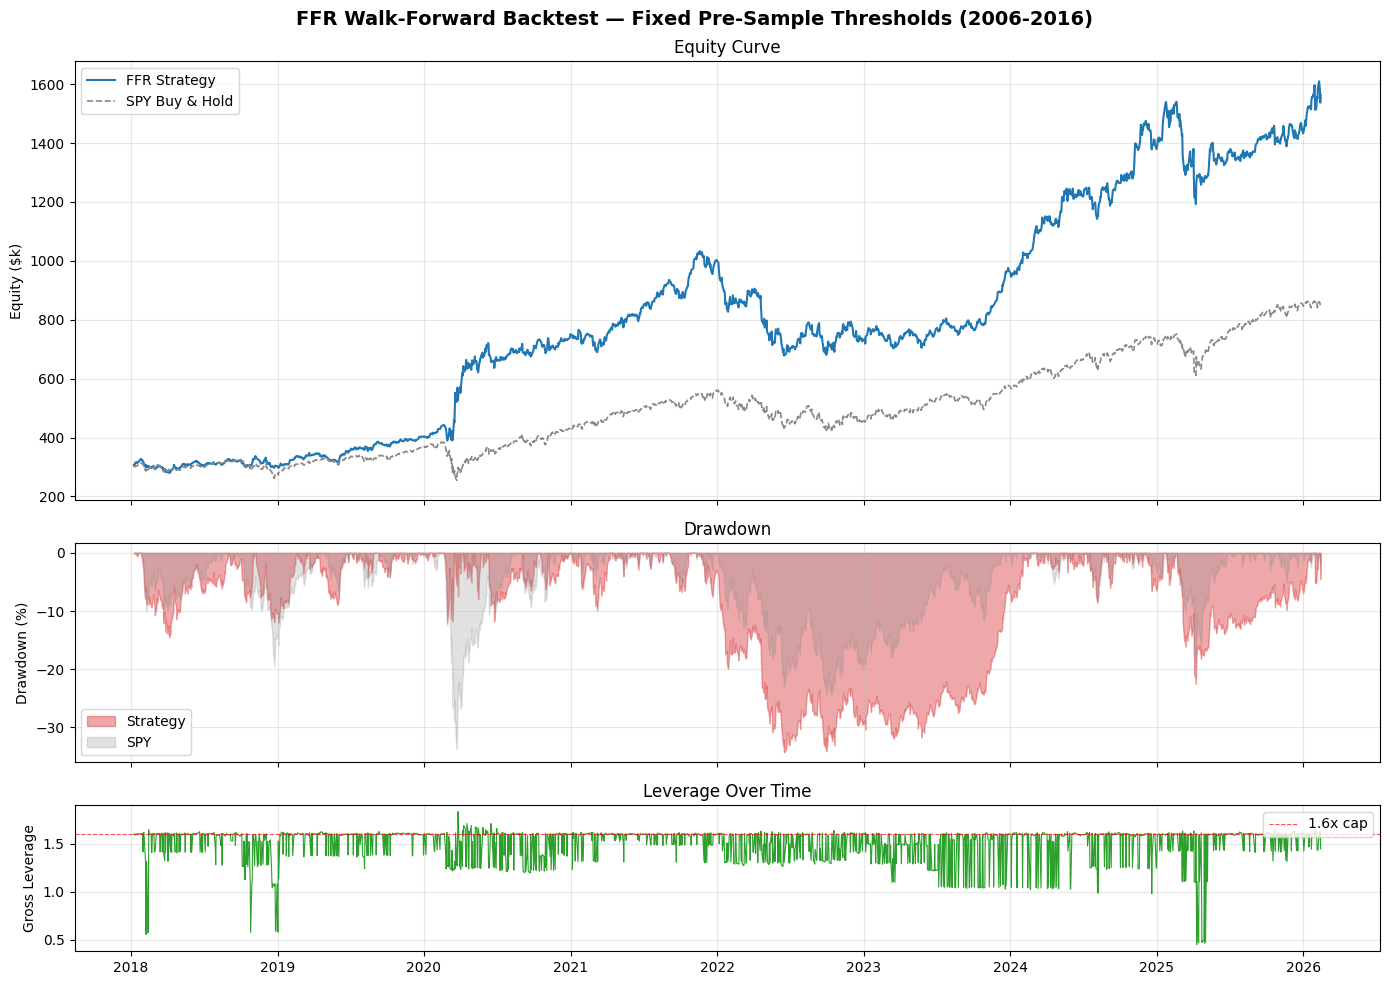


Plot saved: ffr_backtest_results.png


In [11]:
"""
FFR Walk-Forward Backtest — Block 9: Performance Evaluation
============================================================
Metrics, equity curve vs SPY, drawdown, leverage over time.
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import yfinance as yf

# ── SPY benchmark ──
spy = yf.download('SPY', start=results.index[0].strftime('%Y-%m-%d'),
                   end=(results.index[-1] + pd.Timedelta(days=1)).strftime('%Y-%m-%d'),
                   auto_adjust=True)['Close']
if isinstance(spy, pd.DataFrame):
    spy = spy.squeeze()
spy.index = pd.to_datetime(spy.index).tz_localize(None)
spy = spy.reindex(results.index, method='ffill')
spy_equity = initial_equity * (spy / spy.iloc[0])

# ── metrics ──
daily_ret = results['pnl_total'] / results['equity'].shift(1)
daily_ret = daily_ret.dropna()

ann_return = (equity / initial_equity) ** (252 / len(results)) - 1
ann_vol = daily_ret.std() * np.sqrt(252)
sharpe = ann_return / ann_vol

# drawdown
equity_series = results['equity']
running_max = equity_series.cummax()
drawdown = (equity_series - running_max) / running_max
max_dd = drawdown.min()
max_dd_end = drawdown.idxmin()
max_dd_start = equity_series.loc[:max_dd_end].idxmax()

# drawdown duration
dd_duration_days = 0
longest_dd_days = 0
for i in range(len(drawdown)):
    if drawdown.iloc[i] < 0:
        dd_duration_days += 1
        longest_dd_days = max(longest_dd_days, dd_duration_days)
    else:
        dd_duration_days = 0

# calmar
calmar = ann_return / abs(max_dd)

# SPY metrics
spy_ret = spy.pct_change().dropna()
spy_ann_return = (spy.iloc[-1] / spy.iloc[0]) ** (252 / len(spy)) - 1
spy_ann_vol = spy_ret.std() * np.sqrt(252)
spy_sharpe = spy_ann_return / spy_ann_vol
spy_running_max = spy_equity.cummax()
spy_dd = (spy_equity - spy_running_max) / spy_running_max
spy_max_dd = spy_dd.min()

print("=" * 60)
print("PERFORMANCE SUMMARY")
print("=" * 60)
print(f"{'':30s} {'Strategy':>12s} {'SPY B&H':>12s}")
print(f"{'-'*54}")
print(f"{'Initial equity':30s} ${initial_equity:>11,.0f} ${initial_equity:>11,.0f}")
print(f"{'Final equity':30s} ${equity:>11,.0f} ${spy_equity.iloc[-1]:>11,.0f}")
print(f"{'Total return':30s} {(equity/initial_equity-1)*100:>11.1f}% {(spy_equity.iloc[-1]/initial_equity-1)*100:>11.1f}%")
print(f"{'Annualized return':30s} {ann_return*100:>11.1f}% {spy_ann_return*100:>11.1f}%")
print(f"{'Annualized volatility':30s} {ann_vol*100:>11.1f}% {spy_ann_vol*100:>11.1f}%")
print(f"{'Sharpe ratio':30s} {sharpe:>11.2f} {spy_sharpe:>11.2f}")
print(f"{'Max drawdown':30s} {max_dd*100:>11.1f}% {spy_max_dd*100:>11.1f}%")
print(f"{'Max DD period':30s} {str(max_dd_start.date()):>12s} → {str(max_dd_end.date())}")
print(f"{'Longest DD (trading days)':30s} {longest_dd_days:>11d}")
print(f"{'Calmar ratio':30s} {calmar:>11.2f}")
print(f"{'Avg leverage':30s} {results['leverage'].mean():>11.2f}x")
print(f"{'Max leverage':30s} {results['leverage'].max():>11.2f}x")

# ── per-fold table ──
print(f"\n{'='*80}")
print("PER-FOLD BREAKDOWN")
print(f"{'='*80}")
print(f"{'Fold':>4s}  {'OOS Period':>25s}  {'Return':>8s}  {'MaxDD':>8s}  {'Rebals':>6s}  {'AvgLev':>6s}")
print(f"{'-'*68}")
for fold_idx in range(len(folds)):
    fold_data = results[results['fold'] == fold_idx]
    if len(fold_data) == 0:
        continue
    fold_ret = fold_data['pnl_total'].sum() / fold_data['equity'].iloc[0] * 100
    fold_eq = fold_data['equity']
    fold_rm = fold_eq.cummax()
    fold_dd = ((fold_eq - fold_rm) / fold_rm).min() * 100
    fold_rebals = sum(1 for i in range(1, len(fold_data))
                      if fold_data['state'].iloc[i] != fold_data['state'].iloc[i-1]) + 1
    fold_avg_lev = fold_data['leverage'].mean()
    period = f"{fold_data.index[0].date()} → {fold_data.index[-1].date()}"
    print(f"  {fold_idx:>2d}  {period:>25s}  {fold_ret:>+7.1f}%  {fold_dd:>+7.1f}%  {fold_rebals:>6d}  {fold_avg_lev:>5.2f}x")

# ── plots ──
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True,
                          gridspec_kw={'height_ratios': [3, 1.5, 1]})
fig.suptitle('FFR Walk-Forward Backtest — Fixed Pre-Sample Thresholds (2006-2016)', fontsize=14, fontweight='bold')

# equity curve
ax1 = axes[0]
ax1.plot(results.index, results['equity'] / 1000, color='#1f77b4', linewidth=1.5, label='FFR Strategy')
ax1.plot(spy_equity.index, spy_equity / 1000, color='#888888', linewidth=1.2, linestyle='--', label='SPY Buy & Hold')
ax1.set_ylabel('Equity ($k)')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)
ax1.set_title('Equity Curve')

# drawdown
ax2 = axes[1]
ax2.fill_between(drawdown.index, drawdown * 100, 0, color='#d62728', alpha=0.4, label='Strategy')
ax2.fill_between(spy_dd.index, spy_dd * 100, 0, color='#888888', alpha=0.25, label='SPY')
ax2.set_ylabel('Drawdown (%)')
ax2.legend(loc='lower left')
ax2.grid(True, alpha=0.3)
ax2.set_title('Drawdown')

# leverage
ax3 = axes[2]
ax3.plot(results.index, results['leverage'], color='#2ca02c', linewidth=0.8)
ax3.axhline(y=1.6, color='red', linestyle='--', linewidth=0.8, alpha=0.7, label='1.6x cap')
ax3.set_ylabel('Gross Leverage')
ax3.set_xlabel('')
ax3.legend(loc='upper right')
ax3.grid(True, alpha=0.3)
ax3.set_title('Leverage Over Time')

ax3.xaxis.set_major_locator(mdates.YearLocator())
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.tight_layout()
plt.savefig('ffr_backtest_results.png', dpi=150, bbox_inches='tight')
plt.show()
print("\nPlot saved: ffr_backtest_results.png")